In [130]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import json

In [82]:
!pip install -U scikit-learn==1.7.2

# Loading the Dataset

In [83]:
df = pd.read_csv("bike_predictive_maintenance_balanced.csv")

In [84]:
df['maintenance_log'].value_counts()

maintenance_log
Good          150
Brake_Risk    150
Multi_Risk    150
Tire_Risk     150
Name: count, dtype: int64

# checking the missing rows in the dataset

In [85]:
df.isna().sum()

ride_id                0
avg_accel_magnitude    0
std_accel_magnitude    0
max_jerk               0
vibration_index        0
mean_speed             0
max_speed              0
total_distance_m       0
altitude_gain_m        0
num_stops              0
weather                0
timestamp_local        0
lat                    0
lon                    0
timezone               0
suspicious_flag        0
maintenance_log        0
dtype: int64

# Duplicate rows checking

In [86]:
df.duplicated().sum()

np.int64(0)

# Outliers check

In [87]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [88]:
import seaborn as sns

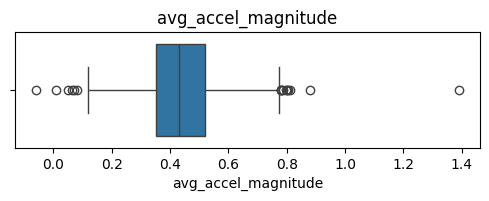

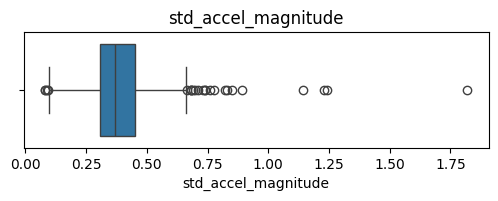

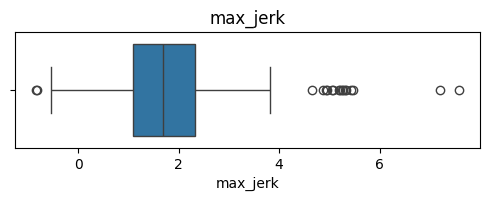

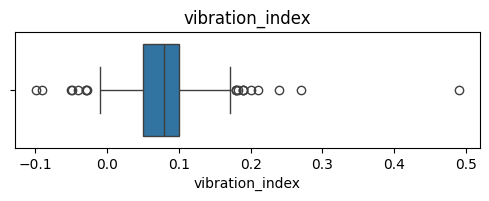

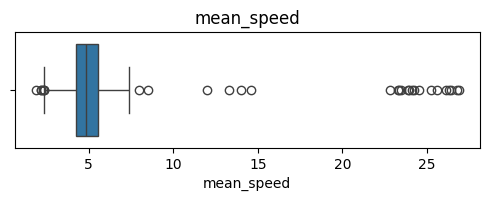

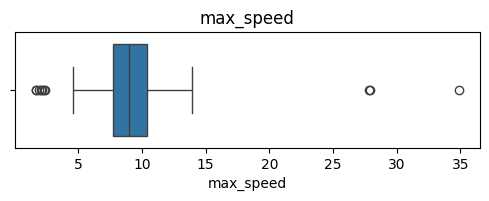

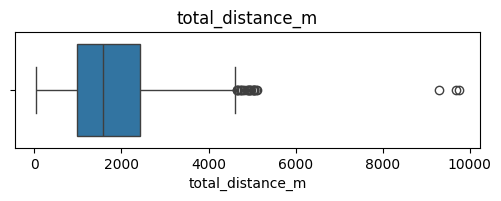

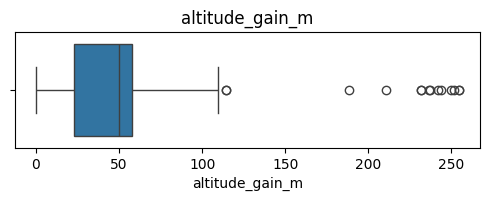

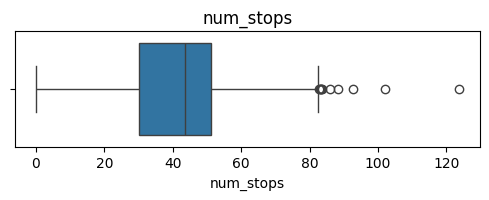

In [89]:
cols = ['avg_accel_magnitude', 'std_accel_magnitude', 'max_jerk', 'vibration_index', 'mean_speed', 'max_speed', 'total_distance_m',
        'altitude_gain_m', 'num_stops']

for c in cols:
    plt.figure(figsize=(6,1.5))
    sns.boxplot(x=df[c])
    plt.title(c)
    plt.show()

# Clipping the outliers

In [90]:
for c in cols:
    lower, upper = np.percentile(df[c], [1, 99])
    df[c] = np.clip(df[c], lower, upper)

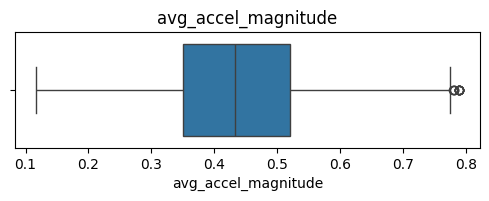

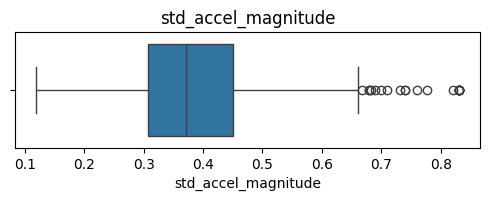

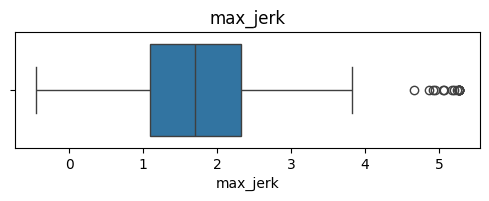

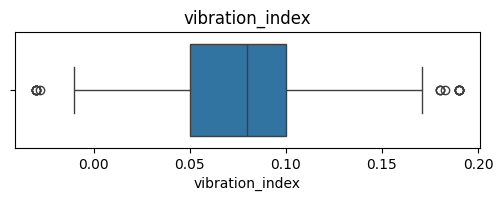

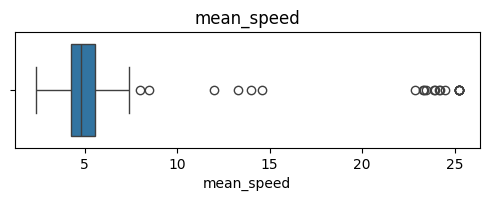

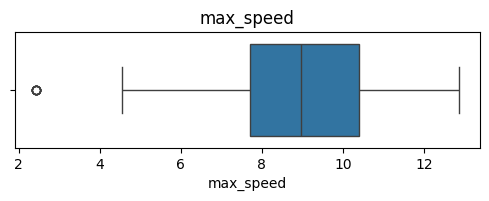

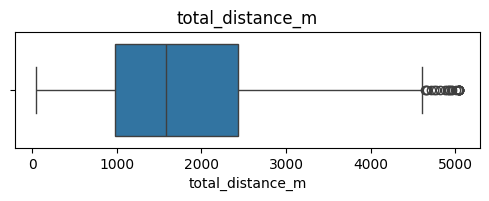

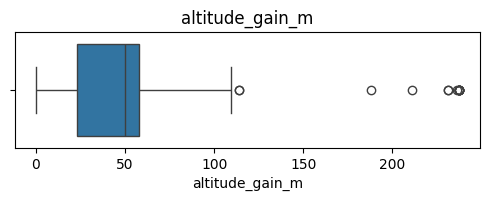

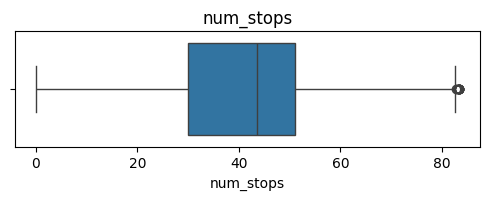

In [91]:
for c in cols:
    plt.figure(figsize=(6,1.5))
    sns.boxplot(x=df[c])
    plt.title(c)
    plt.show()

***Tree based models (like XGBoost , Random forest , LightBGM) are inherently robust to outliers in the input features but still we checked and capped 
accordingly and rest can be handled by my XGboost model which are robust to outliers and also there might be some geniuine pattern that can be learned 
by our model.***

# Feature Engineering

## Speed Variability

In [92]:
df['speed_variability'] = df['std_accel_magnitude'] / (df['mean_speed'] + 1e-5)

*Speed variablility measures how much a rider's acceleration fluctuates compared to their average speed.In essence it captures the smoothness of a ride. Higher variablility means frequent acceleration-deaccelertation cycles , indicating aggressive or inconsistent driving.This will help detect potential brake and tire wear due to frequent speed changes.*

## Vibration to speed ratio

In [93]:
df['vibration_to_speed_ratio'] = df['vibration_index'] / (df['mean_speed'] + 1e-5)

*This ratio compares overall vibration level of a bike to its average speed. If vibration is high even at low speeds it suggest possible issue in tire , brakes or suspension.*

## Stops Per KM

In [94]:
df['stops_per_km'] = df['num_stops'] / ((df['total_distance_m'] / 1000) + 1e-5)

*This represents how many times a rider stops per kilometer of distance travelled. It indicated braking frequency and riding pattern. High values imply frequent braaking which eventually increases brake and chain stress*

## Altitude rate

In [95]:
df['altitude_rate'] = df['altitude_gain_m'] / (df['total_distance_m'] + 1e-5)

*Altitude rate shows how much elevation the bike gains per meter of distance.This features helps the model understands how terrain contributes to mechanical stress.*

In [96]:
df.head()

,ride_id,avg_accel_magnitude,std_accel_magnitude,max_jerk,vibration_index,mean_speed,max_speed,total_distance_m,altitude_gain_m,num_stops,...,timestamp_local,lat,lon,timezone,suspicious_flag,maintenance_log,speed_variability,vibration_to_speed_ratio,stops_per_km,altitude_rate
0,115.948,0.470,0.2150,0.042,0.083,4.63800,4.560,2891.674,13.117,37.48800,...,9/15/25 18:36,29.0910,82.0240,Asia/Kolkata,0.919,Good,0.046356,0.017896,12.964072,0.004536
1,185.715,0.163,0.2230,-0.431,0.053,5.00000,10.422,2473.232,75.220,51.82900,...,9/28/25 15:32,25.6150,80.4850,Asia/Kolkata,0.977,Brake_Risk,0.044600,0.010600,20.955895,0.030414
2,76.748,0.248,0.3940,2.507,0.084,25.22565,10.705,2466.011,32.459,16.23200,...,9/24/25 18:50,27.3850,80.6130,Asia/Kolkata,1.081,Multi_Risk,0.015619,0.003330,6.582263,0.013163
3,255.000,0.780,0.3500,1.920,0.060,5.53000,8.910,4175.980,0.000,40.00000,...,9/9/25 19:07,26.7606,83.3732,Asia/Kolkata,0.000,Good,0.063291,0.010850,9.578567,0.000000
4,63.000,0.220,0.8302,0.920,0.090,13.30000,10.750,695.210,43.840,83.33322,...,9/26/25 11:51,26.7606,83.3732,Asia/Kolkata,1.000,Tire_Risk,0.062421,0.006767,119.865970,0.063060


In [97]:
df.drop(columns = ['lat','lon','timezone'] , inplace = True)

In [98]:
df['weather'].unique()

array(['Rainy', 'Normal', 'Hot'], dtype=object)

# Encoding

In [99]:
df['weather'] = df['weather'].map({'Rainy':0, 'Normal':1,'Hot':2}).astype(int)

In [100]:
from sklearn.preprocessing import LabelEncoder

In [101]:
le = LabelEncoder()
df['maintenance_log'] = le.fit_transform(df['maintenance_log'])

***Since we are going to use tree based model, label encoding won't create any problem.***

In [102]:
df['weather'] = df['weather'].astype(float)
df['maintenance_log'] = df['maintenance_log'].astype(float)
df['suspicious_flag'] = df['suspicious_flag'].astype(float)

***This became necessary in order to have everything in float for my influxdb***

# Train-Test Split

In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [104]:
x = df.drop(columns = ['maintenance_log','timestamp_local','ride_id'])
y = df['maintenance_log']

In [105]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size = 0.2 , random_state = 42)

# Checking For Imbalance

In [106]:
y_train.value_counts()

maintenance_log
1.0    123
2.0    122
3.0    118
0.0    117
Name: count, dtype: int64

***There is no need for balancing the dataset***

# Applying XGBoost

In [107]:
from xgboost import XGBClassifier

In [108]:
!pip install mlflow

In [109]:
import mlflow
from scipy.stats import loguniform,randint
from sklearn.model_selection import RandomizedSearchCV

In [110]:
mlflow.set_experiment("Bike_Prediction_RandomSearch_Experiment")
mlflow.xgboost.autolog()

In [111]:
xgb_model = XGBClassifier(objective = 'multi:softprob',random_state = 42 , eval_metric = 'mlogloss')
param = {"n_estimators":randint(50,100),"max_depth":randint(3,6),"learning_rate":loguniform(.01,.3),"subsample":loguniform(0.5,1.0)}
random_search = RandomizedSearchCV(estimator = xgb_model, param_distributions = param, n_iter = 30, random_state = 42, cv = 5,scoring = "neg_log_loss",n_jobs = -1)

with mlflow.start_run():
    random_search.fit(x_train,y_train)

2026/01/10 23:02:06 INFO mlflow.sklearn.utils: Logging the 5 best runs, 25 runs will be omitted.


In [114]:
best_rf = random_search.best_estimator_

In [115]:
print("best parameter",random_search.best_params_) 

best parameter {'learning_rate': np.float64(0.18013995527645618), 'max_depth': 4, 'n_estimators': 82, 'subsample': np.float64(0.522520067460277)}


In [116]:
y_pred = best_rf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        33
         1.0       0.87      0.96      0.91        27
         2.0       0.93      1.00      0.97        28
         3.0       0.96      0.81      0.88        32

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120



In [120]:
proba = best_rf.predict_proba(x_test)

In [117]:
class_names = list(le.classes_)

In [121]:
proba_df = pd.DataFrame(proba, columns=[f"prob_{c}" for c in class_names])

In [124]:
true_labels = le.inverse_transform(y_test.astype(int))
pred_labels = le.inverse_transform(y_pred.astype(int))

In [125]:
results_df = pd.DataFrame({"True_Label": true_labels,"Predicted_Label": pred_labels})

In [126]:
results_df = pd.concat([results_df, proba_df], axis=1)
results_df.head()

,True_Label,Predicted_Label,prob_Brake_Risk,prob_Good,prob_Multi_Risk,prob_Tire_Risk
0,Tire_Risk,Tire_Risk,0.000587,0.002867,0.002271,0.994275
1,Multi_Risk,Multi_Risk,0.002345,0.000462,0.994677,0.002516
2,Tire_Risk,Tire_Risk,0.000847,0.001088,0.001352,0.996713
3,Tire_Risk,Tire_Risk,0.000321,0.000856,0.001122,0.997702
4,Tire_Risk,Tire_Risk,0.001880,0.002258,0.003839,0.992024


## Saving the model

In [127]:
joblib.dump(best_rf,"xgb_best_model.joblib")

['xgb_best_model.joblib']

In [131]:
json.dump(list(le.classes_), open("class_names.json", "w"))

In [133]:
x_train.columns

Index(['avg_accel_magnitude', 'std_accel_magnitude', 'max_jerk',
       'vibration_index', 'mean_speed', 'max_speed', 'total_distance_m',
       'altitude_gain_m', 'num_stops', 'weather', 'suspicious_flag',
       'speed_variability', 'vibration_to_speed_ratio', 'stops_per_km',
       'altitude_rate'],
      dtype='object')